# Configuracion de grafica a usar

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

# Importacion de librerias

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from IPython.display import display, clear_output
from ipywidgets import interact, IntSlider
import h5py
import numpy as np

%matplotlib inline
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from LTC import *
sys.path.append('../')
from Datasets_utils.DatasetsLoader import VideoDataGenerator

# Configuraciones para Tensorflow y Keras

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
tf.debugging.set_log_device_placement(False)

In [6]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

# Carga de Datos

In [7]:
root_path = "/home/jefelitman/DataSets/jhmdb/fullset_split_1"
root_path

'/home/jefelitman/DataSets/jhmdb/fullset_split_1'

In [9]:
batch_size = 12
original_size = [171,128]
size = [112,112]
frames = 16
canales = 3

In [10]:
def custom_steps_temporal(frames):
    mitad = len(frames)//2
    paso = len(frames)//16
    videos = []
    for i in range(paso):
        indices = range(i, len(frames),paso)
        videos.append([frames[j] for j in indices[:16]])
    return videos

In [11]:
def custom_temp_crop_unique(frames):
    mitad = len(frames)//2
    paso = len(frames)//16
    indices = sorted(list(range(mitad, -1,-paso)) + list(range(mitad+paso, len(frames),paso)))
    indices = indices[len(indices)//2 - 8 : len(indices)//2 + 8]
    return [[frames[i] for i in indices]]

In [12]:
def half_video_temporal(frames):
    mitad = len(frames)//2
    return [frames[mitad-8*2:mitad+8*2]]

In [13]:
def video_transf(video):
    escalador = MinMaxScaler()
    new_video = video.reshape((video.shape[0]*video.shape[1]*video.shape[2]*video.shape[3],1))
    new_video = escalador.fit_transform(new_video)
    return new_video.reshape((video.shape[0],video.shape[1],video.shape[2],video.shape[3]))

In [14]:
def flip_vertical(volume):
    return np.flip(volume, (0, 2))[::-1]

In [15]:
def corner_frame_crop(original_width, original_height):
    x = original_width-112
    y = original_height-112
    return [[x//2, original_width - x//2 -1, y//2, original_height-y//2],
            [x//2, original_width - x//2 -1, y//2, original_height-y//2]
           ]

In [16]:
dataset = VideoDataGenerator(directory_path = root_path, 
                             table_paths = None, 
                             batch_size = batch_size, 
                             original_frame_size = original_size, 
                             frame_size=size, 
                             video_frames = frames, 
                             temporal_crop = ("custom", custom_steps_temporal),
                             video_transformation = [("augmented",flip_vertical)],
                             frame_crop = (None,None),#("custom", corner_frame_crop), 
                             shuffle = True, 
                             conserve_original = False)

# Red Neuronal LTC

### Construccion del modelo

In [17]:
#Entrada de la red neuronal
video_shape = tuple([frames]+size[::-1]+[canales])
dropout = 0.5
lr = 1e-3
weigh_decay = 5e-3

ltc_save_path = '/home/jefelitman/Saved_Models/trained_jhmdb/Inception/inception_enhan/LTC-enhanced_split1_{w}x{h}x{f}_softmax_sgd_'.format(
        w=size[0], h=size[1],f=frames)
if canales == 3:
    ltc_save_path += 'RGB_'
else:
    ltc_save_path += 'B&N_'

ltc_save_path += 'lr={l}_video-flip_temporal-dynamic_batchNorm_pretrained-c3d'.format(l = lr)

#Creacion de la carpeta donde se salvara el modelo
if not os.path.isdir(ltc_save_path):
    os.mkdir(ltc_save_path)
model_saves_path = os.path.join(ltc_save_path,'model_saves')
if not os.path.isdir(model_saves_path):
    os.mkdir(model_saves_path)
ltc_save_path

'/home/jefelitman/Saved_Models/trained_jhmdb/Inception/inception_enhan/LTC-enhanced_split1_112x112x16_softmax_sgd_RGB_lr=0.001_video-flip_temporal-dynamic_batchNorm_pretrained-c3d'

In [18]:
#Parametros para la compilacion del modelo
optimizador = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
#optimizador = keras.optimizers.Adam(learning_rate=lr)
perdida = keras.losses.SparseCategoricalCrossentropy()
precision = keras.metrics.SparseCategoricalAccuracy()

In [19]:
ltc = get_LTC_inception_enhanced(video_shape, len(dataset.to_class), dropout, weigh_decay, 512)

In [20]:
#Compilacion del modelo
ltc.compile(optimizer = optimizador,
           loss = perdida,
           metrics = [precision])

In [21]:
#keras.utils.plot_model(ltc, 'LTC.png', show_shapes=True)

In [22]:
#ltc = keras.models.load_model(os.path.join(ltc_save_path,'ltc_final_1000.h5'))

In [23]:
ltc.summary()

Model: "LTC_BatchNorm_inception-enhanced"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_video (InputLayer)        [(None, 16, 112, 112 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 112, 112, 5248        Input_video[0][0]                
__________________________________________________________________________________________________
batch_norm_1 (BatchNormalizatio (None, 16, 112, 112, 256         conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 16, 56, 56, 6 0           batch_norm_1[0][0]               
___________________________________________________________________

### Cargo los pesos pre entrenados

##### Pesos del C3D

In [24]:
c3d_weights = h5py.File('/home/jefelitman/Saved_Models/c3d-sports1M_weights.h5', 'r')
print(c3d_weights.keys())

<KeysViewHDF5 ['layer_0', 'layer_1', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9']>


In [25]:
c3d_weights['layer_0'].keys()

<KeysViewHDF5 ['param_0', 'param_1']>

In [26]:
weights = []
for capa in ['layer_0','layer_2','layer_4','layer_5','layer_5']:
    weights.append([
        np.moveaxis(np.r_[c3d_weights[capa]['param_0']], (0,1),(4,3)), #Cambio los ejes porque c3d estan con canales primero
        np.r_[c3d_weights[capa]['param_1']]
                   ])
for index, capa in enumerate(['conv3d_1','conv3d_2','conv3d_3','conv3d_4','conv3d_5']):
    ltc.get_layer(capa).set_weights(weights[index])

##### Pesos de la InceptionV3

### Entrenamiento de la red con el generador

In [27]:
#Funcion customizadas para el entrenamiento del modelo 
def cambio_lr(epoch, lr):
    if epoch == 4 or epoch == 8 :
        for i in ['conv3d_1','conv3d_2','conv3d_3','conv3d_4','conv3d_5']:
            weigh_decay = ltc.get_layer(i).kernel_regularizer.get_config()['l2'] * 0.1
            ltc.get_layer(i).kernel_regularizer = keras.regularizers.l2(weigh_decay)
        return optimizador.learning_rate.numpy() * 0.1
    else:
        return optimizador.learning_rate.numpy()

funciones = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_saves_path,'ltc_epoch_{epoch}.h5'),
        save_best_only=True,
        monitor='val_sparse_categorical_accuracy',
        verbose=1),
    keras.callbacks.LearningRateScheduler(cambio_lr, verbose=1),
    keras.callbacks.CSVLogger(os.path.join(ltc_save_path,'output.csv'))
]

In [28]:
epoch = 10
historial = ltc.fit(x = dataset.get_train_generator(canales),
                 steps_per_epoch=dataset.train_batches,
                 epochs=epoch,
                 callbacks=funciones,
                 validation_data= dataset.get_test_generator(canales),
                 validation_steps=dataset.test_batches,
                 max_queue_size=batch_size%24)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 180 steps, validate for 73 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/10
179/180 [============================>.] - ETA: 1s - loss: 29.7920 - sparse_categorical_accuracy: 0.3003
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.15639, saving model to /home/jefelitman/Saved_Models/trained_jhmdb/Inception/inception_enhan/LTC-enhanced_split1_112x112x16_softmax_sgd_RGB_lr=0.001_video-flip_temporal-dynamic_batchNorm_pretrained-c3d/model_saves/ltc_epoch_1.h5
180/180 [==============================] - 289s 2s/step - loss: 29.7897 - sparse_categorical_accuracy: 0.3009 - val_loss: 29.4110 - val_sparse_categorical_accuracy: 0.1564

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/10
179/180 [============================>.] - ETA: 0s - loss: 27.5680 - sparse_categorical_accuracy: 0.6276
Epoch 00002: val_sparse_categorical_accuracy improved from 0.15639 

### Guardado del modelo 

In [29]:
#Salvado final definitivo del modelo una vez se detenga
ltc.save(os.path.join(ltc_save_path,"ltc_final_{e}.h5".format(e=epoch)))

### Graficas de los resultados de entrenamiento

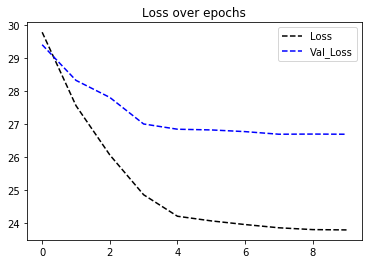

In [30]:
fig = plt.figure()
plt.plot(historial.history["loss"],'k--')
plt.plot(historial.history["val_loss"],'b--')
plt.title('Loss over epochs')
plt.legend(labels=["Loss","Val_Loss"])
plt.show()
fig.savefig(os.path.join(ltc_save_path,'train_loss_epochs_{e}.png'.format(e=epoch)))

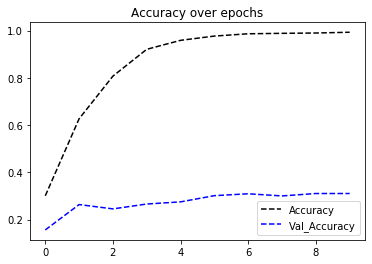

In [31]:
fig = plt.figure()
plt.plot(historial.history["sparse_categorical_accuracy"],'k--')
plt.plot(historial.history["val_sparse_categorical_accuracy"],'b--')
plt.title('Accuracy over epochs')
plt.legend(labels=["Accuracy","Val_Accuracy"])
plt.show()
fig.savefig(os.path.join(ltc_save_path,'train_accuracy_epochs_{e}.png'.format(e=epoch)))

### Evaluacion del entrenamiento